In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
import torch.optim as optim
import random

In [4]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: dataset/Beagle/Beagle_1.jpg  
  inflating: dataset/Beagle/Beagle_10.jpg  
  inflating: dataset/Beagle/Beagle_100.jpg  
  inflating: dataset/Beagle/Beagle_11.jpg  
  inflating: dataset/Beagle/Beagle_12.jpg  
  inflating: dataset/Beagle/Beagle_13.jpg  
  inflating: dataset/Beagle/Beagle_14.jpg  
  inflating: dataset/Beagle/Beagle_15.jpg  
  inflating: dataset/Beagle/Beagle_16.jpg  
  inflating: dataset/Beagle/Beagle_17.jpg  
  inflating: dataset/Beagle/Beagle_18.jpg  
  inflating: dataset/Beagle/Beagle_19.jpg  
  inflating: dataset/Beagle/Beagle_2.jpg  
  inflating: dataset/Beagle/Beagle_20.jpg  
  inflating: dataset/Beagle/Beagle_21.jpg  
  inflating: dataset/Beagle/Beagle_22.jpg  
  inflating: dataset/Beagle/Beagle_23.jpg  
  inflating: dataset/Beagle/Beagle_24.jpg  
  inflating: dataset/Beagle/Beagle_25.jpg  
  inflating: dataset/Beagle/Beagle_26.jpg  
  inflating: dataset/Beagle/Beagle_27.jpg  
  inflating: dataset/Beagle/Beagle_28.jpg  
  

In [9]:
image_size=64

classes = sorted(os.listdir('/content/dataset'))
num_classes = len(classes)

class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
print(class_to_idx)

x=[]
y=[]

for cls in classes:
  cls_path=os.path.join('/content/dataset', cls)
  label=class_to_idx[cls]

  for image_name in os.listdir(cls_path):
    image_path=os.path.join(cls_path, image_name)
    image=Image.open(image_path).convert("RGB")
    image=image.resize((image_size, image_size))
    image=np.array(image)

    x.append(image)
    y.append(label)

x=np.array(X)
y=np.array(y)
one_hot=OneHotEncoder(sparse_output=False)
Y=one_hot.fit_transform(y.reshape(-1,1))
print(f"Images shape: {x.shape}")
print(f"Labels shape: {Y.shape}")

{'Beagle': 0, 'Boxer': 1, 'Bulldog': 2, 'Dachshund': 3, 'German_Shepherd': 4, 'Golden_Retriever': 5, 'Labrador_Retriever': 6, 'Poodle': 7, 'Rottweiler': 8, 'Yorkshire_Terrier': 9}
Images shape: (967, 64, 64, 3)
Labels shape: (967, 10)


In [8]:
class MLP(nn.Module):
  def __init__(self, num_classes):
        super().__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*64*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()

  def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
x = torch.tensor(x, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

train_size = int(0.8 * len(x))
val_size = int(0.1 * len(x))
test_size = len(x) - train_size - val_size
dataset = TensorDataset(x, Y)
train_ds, val_ds, test_ds = random_split(dataset,[train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

model = MLP(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epochs = 30

/tmp/ipython-input-223170877.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


In [13]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        labels_indices_train = torch.argmax(labels, dim=1)
        correct += (preds == labels_indices_train).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            labels_indices_val = torch.argmax(labels, dim=1)
            correct += (preds == labels_indices_val).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/30] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")


model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        labels_indices_test = torch.argmax(labels, dim=1)
        correct += (preds == labels_indices_test).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Epoch [5/30] | Train Loss: 10.591, Train Acc: 0.393 | Val Loss: 10.414, Val Acc: 0.344
Epoch [10/30] | Train Loss: 2.336, Train Acc: 0.677 | Val Loss: 2.843, Val Acc: 0.583
Epoch [15/30] | Train Loss: 0.223, Train Acc: 0.944 | Val Loss: 0.253, Val Acc: 0.906
Epoch [20/30] | Train Loss: 0.189, Train Acc: 0.944 | Val Loss: 0.775, Val Acc: 0.875
Epoch [25/30] | Train Loss: 1.665, Train Acc: 0.768 | Val Loss: 3.692, Val Acc: 0.583
Epoch [30/30] | Train Loss: 0.389, Train Acc: 0.890 | Val Loss: 0.010, Val Acc: 1.000

Test Loss: 0.025
Test Accuracy: 0.980


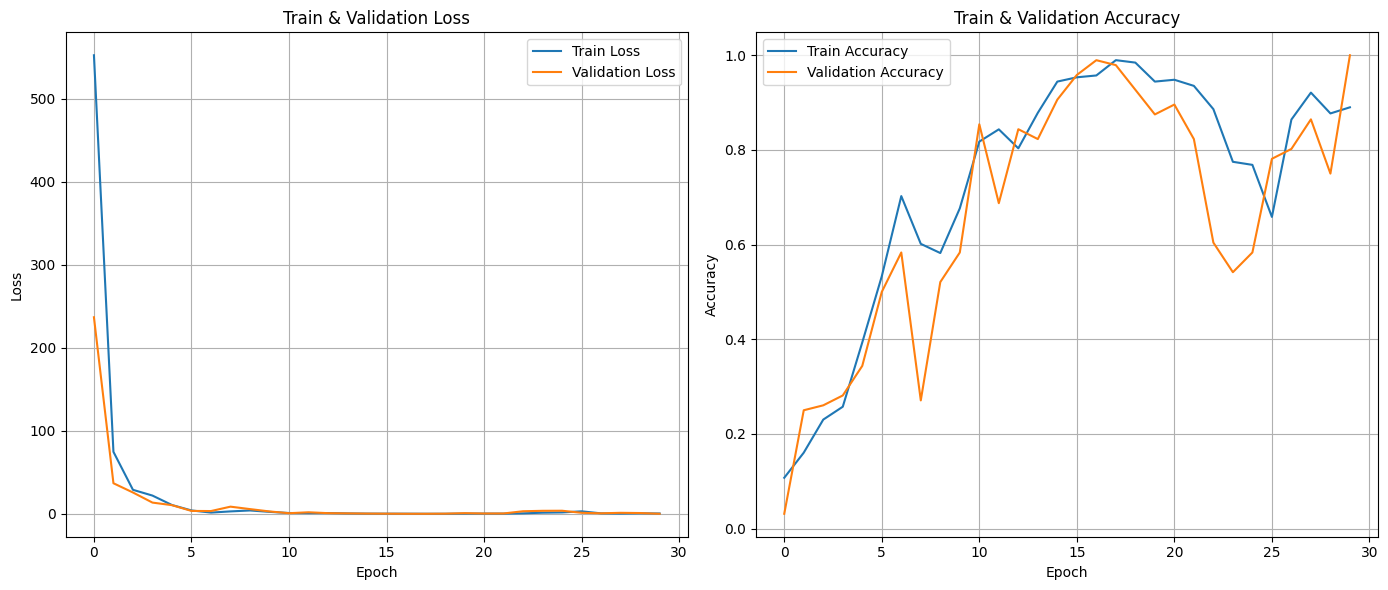

In [14]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Βάσει των παραπάνω διαγραμμάτων, το σύνολο δεδομένων φαίνεται να είναι έντονα διαχωρίσιμο, γεγονός που επιτρέπει ακόμη και σε ένα απλό MLP με τρία γραμμικά επίπεδα να επιτυγχάνει περίπου 90% ακρίβεια στο σύνολο ελέγχου. Η συνολική ακρίβεια προσεγγίζει το 100%, κάτι που αποτελεί ένδειξη υπερπροσαρμογής. Για τον λόγο αυτό, είναι σημαντικό να μειωθεί τόσο ο αριθμός των εποχών όσο και η πολυπλοκότητα του μοντέλου, ώστε να επιτευχθεί καλύτερη γενίκευση.

Επιπλέον, μπορούν να εφαρμοστούν τεχνικές όπως κανονικοποίηση καθώς και συστηματική ρύθμιση υπερπαραμέτρων με στόχο τη μείωση της πολυπλοκότητας του μοντέλου και την αποφυγή υπερπροσαρμογής στο μέλλον.

In [16]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)  # 64->32->16

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))  # (B,32,64,64)
        x = self.pool(x)              # (B,32,32,32)

        x = self.relu(self.conv2(x))  # (B,64,32,32)
        x = self.pool(x)              # (B,64,16,16)

        x = self.flatten(x)           # (B,64*16*16)
        x = self.relu(self.fc1(x))    # (B,128)
        x = self.fc2(x)               # (B,num_classes) logits
        return x

model = CNN(num_classes=num_classes)
X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)
y_tensor = torch.tensor(y, dtype=torch.long)                        # (N,)

dataset = TensorDataset(X_tensor, y_tensor)


N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    running_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_loader)
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

/tmp/ipython-input-1192139559.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  # (N,3,64,64)


Epoch [5/30] | Train Loss: 0.035, Train Acc: 0.993 | Val Loss: 0.123, Val Acc: 0.979
Epoch [10/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.153, Val Acc: 0.979
Epoch [15/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.163, Val Acc: 0.979
Epoch [20/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.169, Val Acc: 0.979
Epoch [25/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.173, Val Acc: 0.979
Epoch [30/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.177, Val Acc: 0.979

Test Loss: 0.118
Test Accuracy: 0.986


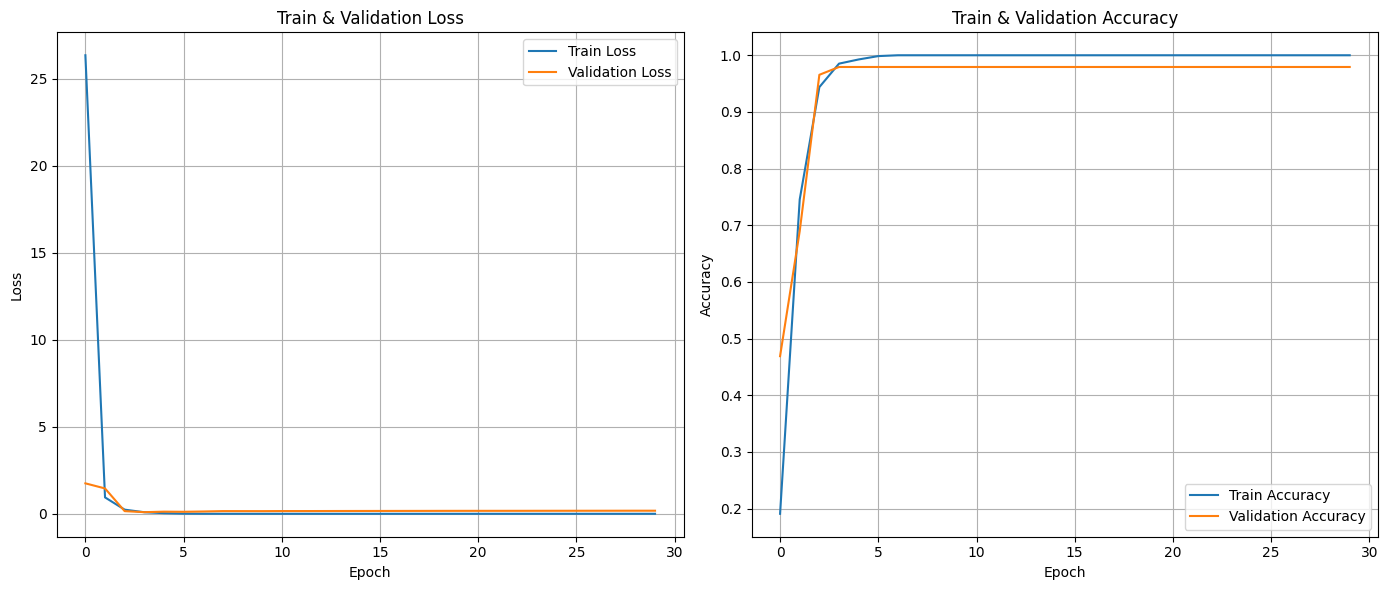

In [17]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Με βάση τις μετρικές στο σύνολο ελέγχου, η αρχιτεκτονική CNN πέτυχε συνολικά καλύτερα αποτελέσματα σε σχέση με το MLP. Η διαφορά στην ακρίβεια των δύο μοντέλων είναι πολύ μικρή, γεγονός που δείχνει ότι και τα δύο αποδίδουν σε υψηλό επίπεδο. Ωστόσο, στην περίπτωση του CNN παρατηρείται υπερπροσαρμογή, καθώς η απώλεια εκπαίδευσης έφτασε στο 0.00 και η ακρίβεια στην εκπαίδευση άγγιξε από πολύ νωρίς το 100%.

Τα CNN αποτελούν πιο κατάλληλη επιλογή για δεδομένα εικόνων σε σχέση με τα MLP, επειδή μπορούν να εξάγουν χαρακτηριστικά από όλη την επιφάνεια της εικόνας και όχι μόνο από συγκεκριμένα σημεία. Μαθαίνουν ιεραρχικά χαρακτηριστικά: τα αρχικά επίπεδα αναγνωρίζουν απλά μοτίβα, ενώ τα βαθύτερα συνδυάζουν αυτά τα μοτίβα για να σχηματίσουν πιο σύνθετες αναπαραστάσεις. Αυτή η σταδιακή κατανόηση της δομής της εικόνας επιτρέπει στο CNN να αποτυπώνει καλύτερα τις συσχετίσεις μέσα στα δεδομένα.

Επιπλέον, το CNN παρουσιάζει μικρότερη απόκλιση ανάμεσα στην ακρίβεια εκπαίδευσης και επικύρωσης, στοιχείο που υποδεικνύει καλύτερη γενίκευση. Η ανθεκτικότητά του σε μεταβολές της χωρικής θέσης τοπικών μοτίβων προκύπτει από τεχνικές όπως το weight sharing και το pooling, οι οποίες μειώνουν την ευαισθησία του μοντέλου σε μικρές παραλλαγές των εισόδων.

In [18]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))

        x = self.flatten(x)
        x = self.dropout(self.relu(self.bn_fc1(self.fc1(x))))
        x = self.fc2(x)

        return x

In [19]:
x = x / 255.0

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

x = (x - mean) / std

X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)
y_tensor = torch.tensor(y, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)


N = len(dataset)
train_size = int(0.7 * N)
val_size   = int(0.15 * N)
test_size  = N - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []
for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)


    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
              f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")

model.eval()
test_loss = 0.0
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        test_loss /= len(test_loader)
test_acc = correct / total

print(f"\nTest Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

/tmp/ipython-input-2537764228.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = (x - mean) / std
/tmp/ipython-input-2537764228.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)


Epoch [5/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.002, Val Acc: 1.000
Epoch [10/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.004, Val Acc: 1.000
Epoch [15/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.008, Val Acc: 1.000
Epoch [20/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.014, Val Acc: 0.993
Epoch [25/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.024, Val Acc: 0.993
Epoch [30/30] | Train Loss: 0.000, Train Acc: 1.000 | Val Loss: 0.003, Val Acc: 1.000

Test Loss: 0.000
Test Accuracy: 1.000


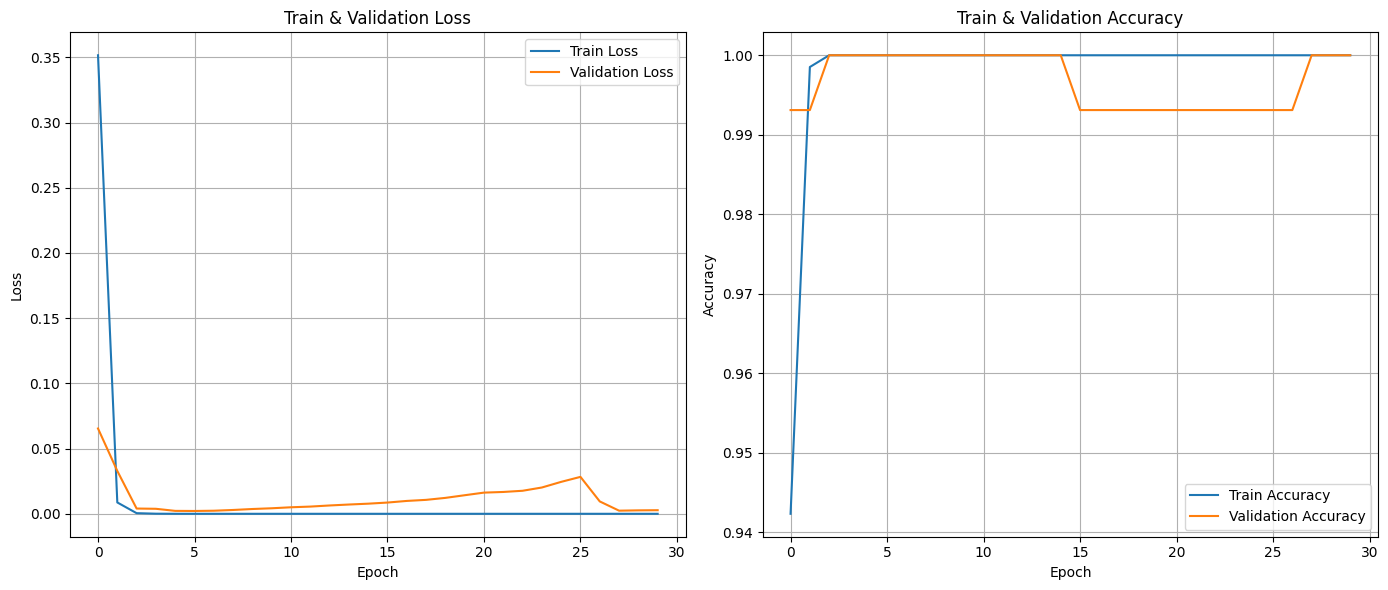

In [20]:
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

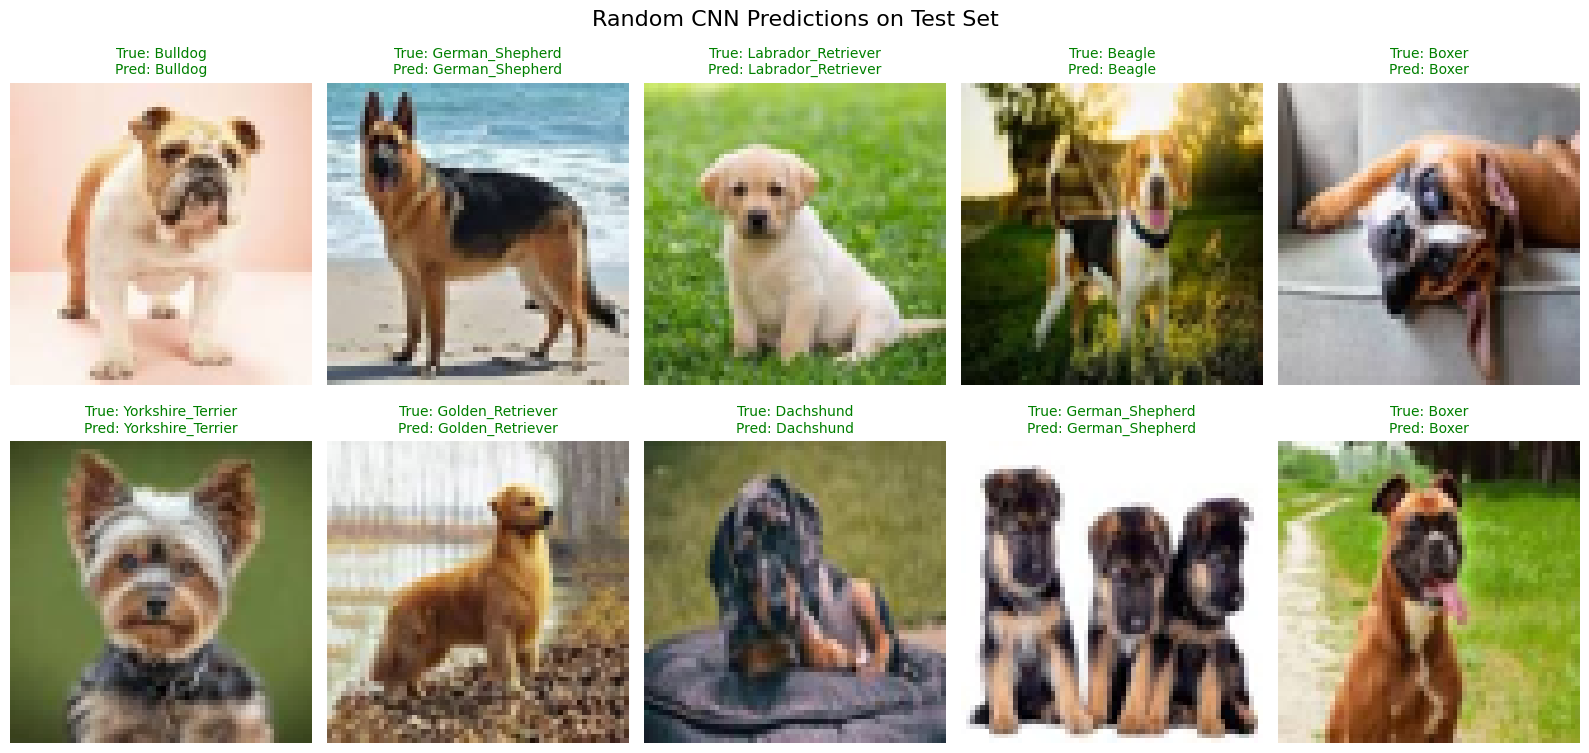

In [22]:
idx_to_class = {
    0: 'Beagle',
    1: 'Boxer',
    2: 'Bulldog',
    3: 'Dachshund',
    4: 'German_Shepherd',
    5: 'Golden_Retriever',
    6: 'Labrador_Retriever',
    7: 'Poodle',
    8: 'Rottweiler',
    9: 'Yorkshire_Terrier'
}

model.eval()
num_images = 10
images, labels = next(iter(test_loader))

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)


indices = random.sample(range(images.size(0)), num_images)

plt.figure(figsize=(16, 8))

for i, idx in enumerate(indices):
    img = images[idx].cpu().numpy()
    img = np.transpose(img, (1, 2, 0))

    img = img - img.min()
    img = img / img.max()
    true_label = idx_to_class[labels[idx].item()]
    pred_label = idx_to_class[preds[idx].item()]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

    color = "green" if labels[idx] == preds[idx] else "red"
    plt.title(
        f"True: {true_label}\nPred: {pred_label}",
        color=color,
        fontsize=10)

plt.suptitle("Random CNN Predictions on Test Set", fontsize=16)
plt.tight_layout()
plt.show()